In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random

# Penguins Dataset

Part of our discussion has been sampling with or without replacement. We use random.sample(list, k=n) for sampling from a population without replacement, and random.choices(list, k=n) for sampling from a population with replacement. The general guidelines:

- we can use sampling with replacement if the sample size is small compared to the size of the population. 
- Sampling without replacement is more appropriate if the sample size is large compared to the population (the question we should ask is whether the sample selction could change the distribution.
- Sampling with replacement is also called for if the category of interest in the population is small compared to the population size.

## Bootstrapping

Today's example is another case where samping with replacement is called for. In many cases the data we have does not represent the whole population but is itself a sample from the population. Consider the examples we have seen so far for resampling:

- Baseball Players:  Our dataset was all of the players in one season.
- Presidential Pardons:  Our dataset was all of the recent pardon petitions.
- PPP Data: Our dataset was all of the large PPP loans (well except for the ones with no state listed or no jobs reported as saved)
- Airline Flights:  Our dataset was all of the flights in one year.
- Class Performance:  Our data (not really a dataset) was the grade distributions from multiple years worth of students in MATH 120.

Compare these with the penguin data:  We have a dataset of measurments taken from selected penguins from three islands in Antarctica.  Clearly our dataset is not the population of all penguins but just a sample from it. 

- Problems with the original sampling methadology that built the dataset.
- The number of times we run the experiment.
- Irreducible errors in the data.

What we would like to try and understand is what is the potential variablity in the mean when the data we have is just a sample of the population.

In [2]:
# Let's continue exploring the penguins data set (our first Case Study that we will work on together)

penguins_url = 'https://drive.google.com/uc?export=download&id=1-SiGKvihMs9sP2I2FZd-sVRm-VnZFihi'
penguins_data = pd.read_csv(penguins_url)
penguins_data

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


Consider just the set of bill lengths of the Adelie penguins. Make a DataFrame, Series, or list of those numbers.

In [4]:
pop_sample = penguins_data.loc[penguins_data.loc[:, 'species']=='Adelie', 'bill_length_mm'].dropna()
pop_sample

0      39.1
1      39.5
2      40.3
4      36.7
5      39.3
       ... 
147    36.6
148    36.0
149    37.8
150    36.0
151    41.5
Name: bill_length_mm, Length: 151, dtype: float64

### Q1:  Make a plot of the distribution of the bill_lengths of the penguins.

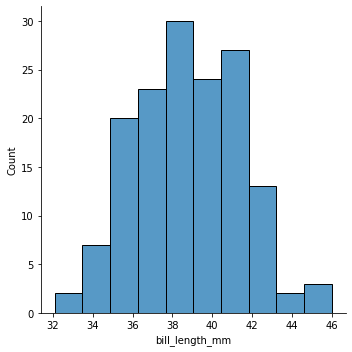

In [5]:
sns.displot(data=pop_sample);

### Q2: Find the mean bill length for the Adelie penguins.

In [6]:
pop_sample.mean()

38.79139072847682

### Q3:  How many Adelie penguins do we have in our population sample? 

In [7]:
size = len(pop_sample)
size

151

## Variability

### Standard Deviation

There are two types of measures of variability we us. One is the **Standard Deviation** and the related **Variance**.

The *Variance* of a number is average of the squares of the values differences from the mean:

$$ \mbox{Variance} = \frac{1}{N-1} \sum_{n=1}^N \left( x_i - \bar{x} \right)^2 $$

Note that it is not *exactly* the average, we divide by N-1. This because the mean $$\bar{x}$$ is included and that is reducing the degrees of freedom by 1, hence $$N -1$$ is what we divide by.

The problem with Variance is that the units it has are the square of the units of our variable. This is not great for actually comparing the spread of our data with the data itself, and so we take the square root of the variance to give the standard deviation:

$$ \mbox{Standard Deviation} = \sqrt{ \mbox{Variance} } $$

The larger the *Standard Deviation* the more our data is spread away from the mean. In the case of the Guassian distribution *Standard Deviation* has a precise meaning and interpretation, but for our purposes it is more useful to just treat it as the appropriate measure of spread if we are working with the mean.

Python can compute it.


In [8]:
pop_sample.std()

2.663404848368619

Larger standard deviations indicate more spread.

### Percentiles and Quartiles

The other notion of spread, related to the *median* is the locations of quartiles and percentiles for the data. The advantage of this measurment over Standard Deviation is it neglects the distance of the data points from each other and in particular is less influenced by outliers and very large values (like for the median).  The pth percentile is the value where p percent of the data is at that value or less.

In [9]:
pop_sample.quantile(q=0.25), pop_sample.median(), pop_sample.quantile(q=0.75)

(36.75, 38.8, 40.75)

Note for this problem the quartiles and standard deviation are relatively close in their notion of spread. This indicates the data does not have values that are significantly different from the rest of the values.

## How much does the mean vary?

Our question though is not really how much variablity there is in individual Adelie penguins, but how much the mean of the population sample we have taken should be expected to vary.

What we have is a sample of the population and so the best we can do is use that. What we will do is choose sets of bill lenghts from the Adelie lengths with replacement that are the same size as the original population sample. 

Let me pause and point out that this means, because the sample size is large we are likely to repeat a penguin in our sample, because we are likely to repeat one, that also means we are likely to skip others. This is actually a feature, we are going to learn how important the presence of small changes like that are to our conclusions.

The following function is going to run our **bootstrap** of the data. In this case the size of the sample we draw for the experiment will match the size of the population sample we have.

I'm writing the function so it returns the means. You will need to modify it to return the medians.

In [22]:
def experiment(N, s=size, pop = list(pop_sample)):
    
    # The random functions are a little touchy. They work best when we pass them a list. When I pass them pop_sample
    # the pandas series, sometimes it works fine and sometimes it does not.
    
    result = pd.DataFrame([], columns=['Sample Mean'])
    
    for k in range(N):
        sample = random.choices(pop, k=s)  # We have to use replacement here because the set we are building
                                           # is the same size as the population sample.
        
        result.loc[k, 'Sample Mean'] = np.mean(sample)  # Note I have to use the Numpy Mean because we are acting on list
        if pd.isna(result.loc[k, 'Sample Mean']):
            print(sample)
        
        
    return result

In [26]:
result = experiment(200)
result

,Sample Mean
0,38.9636
1,38.9781
2,38.955
3,39.2629
4,38.445
...,...
195,38.7702
196,39.247
197,38.7755
198,38.649


In [33]:
result.iloc[:, 0].std()

0.2382874374524277

In [32]:
result.iloc[:, 0].quantile(q=0.25), result.iloc[:, 0].median(), result.iloc[:, 0].quantile(q=0.75)

(38.65596026490066, 38.8069536423841, 38.97831125827815)